#DỰ ĐOÁN GIÁ CỔ PHIẾU BẰNG THUẬT TOÁN RANDOM FOREST

In [ ]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.8 MB/s eta 0:00:00


In [ ]:
#Thao tác với dữ liệu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import random
import copy
import pickle
#Trực quan hóa dữ liệu
from graphviz import Digraph
from IPython.display import display
# import mplfinance as mpf
import plotly.graph_objects as go
#Làm việc với model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression

1 Chuẩn bị dữ liệu

1.1. Tải dữ liệu cổ phiếu

Dữ liệu theo ngày

In [ ]:
# Danh sách các mã cổ phiếu
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']

dfs = {}
data_frames = []
for ticker in tickers:
  # Tải dữ liệu
  data_frame = yf.download(ticker, start="2023-01-01", end="2024-12-31")
  # Chuyển về data frame level 1
  df_flat = data_frame.stack(level=1).reset_index()
  df_flat.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
  data_frames.append(df_flat)

# Kết hợp các bảng
df_day = pd.concat(data_frames)
# Đặt lại chỉ số của DataFrame đã được kết hợp
df_day.reset_index(drop=True, inplace=True)

dfs['day'] = df_day
df_day


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-3-6e1c7d324bdf>:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_flat = data_frame.stack(level=1).reset_index()
[*********************100%***********************]  1 of 1 completed
<ipython-input-3-6e1c7d324bdf>:10: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_flat = data_frame.stack(level=1).reset_index()
[*********************100%***********************]  1 of 1 completed
<ipython-input-3-6e1c7d324bdf>:10: FutureWarning: The previous implementation of stack is deprecated and wi

,Date,Ticker,Open,High,Low,Close,Volume
0,2023-01-03,AAPL,123.470612,129.226052,122.582119,128.613985,112117500
1,2023-01-04,AAPL,124.744125,127.014716,123.480495,125.267347,89113600
2,2023-01-05,AAPL,123.421249,126.136083,123.164580,125.504267,80962700
3,2023-01-06,AAPL,127.962418,128.623848,123.292909,124.398589,87754700
4,2023-01-09,AAPL,128.485626,131.703947,128.228957,128.801541,70790800
...,...,...,...,...,...,...,...
1999,2024-12-23,TSLA,430.600006,434.510010,415.410004,431.000000,72698100
2000,2024-12-24,TSLA,462.279999,462.779999,435.140015,435.899994,59551800
2001,2024-12-26,TSLA,454.130005,465.329987,451.019989,465.160004,76366400
2002,2024-12-27,TSLA,431.660004,450.000000,426.500000,449.519989,82666800


Theo tuần

In [ ]:
# Danh sách các mã cổ phiếu
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']

data_frames = []
for ticker in tickers:
  # Tải dữ liệu
  data_frame = yf.download(ticker, start="2016-01-01", end="2024-12-31", interval="1wk")
  # Chuyển về data frame level 1
  df_flat = data_frame.stack(level=1).reset_index()
  df_flat.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
  data_frames.append(df_flat)

# Kết hợp các bảng
df_week = pd.concat(data_frames)
# Đặt lại chỉ số của DataFrame đã được kết hợp
df_week.reset_index(drop=True, inplace=True)

dfs['week'] = df_week
df_week


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-03fa334ef202>:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_flat = data_frame.stack(level=1).reset_index()
[*********************100%***********************]  1 of 1 completed
<ipython-input-4-03fa334ef202>:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_flat = data_frame.stack(level=1).reset_index()
[*********************100%***********************]  1 of 1 completed
<ipython-input-4-03fa334ef202>:9: FutureWarning: The previous implementation of stack is deprecated and will 

,Date,Ticker,Open,High,Low,Close,Volume
0,2016-01-01,AAPL,21.792263,23.916134,21.787745,23.184077,1091968800
1,2016-01-08,AAPL,22.485912,22.863240,21.631846,22.266748,1181205200
2,2016-01-15,AAPL,21.758371,22.289339,21.107653,21.735776,1029670000
3,2016-01-22,AAPL,21.259035,22.940056,20.874932,22.284819,1526882000
4,2016-01-29,AAPL,21.826153,21.993351,21.256776,21.417195,940612800
...,...,...,...,...,...,...,...
1875,2024-11-29,TSLA,369.489990,375.429993,334.649994,336.079987,305635800
1876,2024-12-06,TSLA,418.100006,429.299988,370.799988,377.420013,467418400
1877,2024-12-13,TSLA,436.170013,488.540009,415.709991,420.000000,602213900
1878,2024-12-20,TSLA,454.130005,465.329987,415.410004,425.510010,340832500


Theo tháng

In [ ]:
# Danh sách các mã cổ phiếu
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']

data_frames = []
for ticker in tickers:
  # Tải dữ liệu
  data_frame = yf.download(ticker, start="2000-01-01", end="2024-12-31", interval="1mo")
  # Chuyển về data frame level 1
  df_flat = data_frame.stack(level=1).reset_index()
  df_flat.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
  data_frames.append(df_flat)

# Kết hợp các bảng
df_month = pd.concat(data_frames)
# Đặt lại chỉ số của DataFrame đã được kết hợp
df_month.reset_index(drop=True, inplace=True)

dfs['month'] = df_month
df_month


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-946a4697e946>:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_flat = data_frame.stack(level=1).reset_index()
[*********************100%***********************]  1 of 1 completed
<ipython-input-5-946a4697e946>:9: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_flat = data_frame.stack(level=1).reset_index()
[*********************100%***********************]  1 of 1 completed
<ipython-input-5-946a4697e946>:9: FutureWarning: The previous implementation of stack is deprecated and will 

,Date,Ticker,Open,High,Low,Close,Volume
0,2000-01-01,AAPL,0.779530,0.912895,0.649921,0.787983,12555177600
1,2000-02-01,AAPL,0.861241,0.901157,0.728814,0.781409,7319782400
2,2000-03-01,AAPL,1.020434,1.129849,0.856544,0.890825,8698356800
3,2000-04-01,AAPL,0.932149,1.048140,0.787983,1.018085,8662404800
4,2000-05-01,AAPL,0.631138,0.948585,0.614233,0.938254,9807750400
...,...,...,...,...,...,...,...
1015,2024-08-01,TSLA,214.110001,231.869995,182.000000,227.690002,1618373100
1016,2024-09-01,TSLA,261.630005,264.859985,209.639999,215.259995,1611273300
1017,2024-10-01,TSLA,249.850006,273.540009,212.110001,262.670013,1910807800
1018,2024-11-01,TSLA,345.160004,361.929993,238.880005,252.039993,2091913900


1.2. Làm sạch dữ liệu

In [ ]:
# Kiểm tra dữ liệu thiếu
times = ['day', 'week', 'month']
for time in times:
  dfs[time].isnull().sum()
  dfs[time].dropna(inplace=True)
dfs['day']

,Date,Ticker,Open,High,Low,Close,Volume
0,2023-01-03,AAPL,123.470612,129.226052,122.582119,128.613985,112117500
1,2023-01-04,AAPL,124.744125,127.014716,123.480495,125.267347,89113600
2,2023-01-05,AAPL,123.421249,126.136083,123.164580,125.504267,80962700
3,2023-01-06,AAPL,127.962418,128.623848,123.292909,124.398589,87754700
4,2023-01-09,AAPL,128.485626,131.703947,128.228957,128.801541,70790800
...,...,...,...,...,...,...,...
1999,2024-12-23,TSLA,430.600006,434.510010,415.410004,431.000000,72698100
2000,2024-12-24,TSLA,462.279999,462.779999,435.140015,435.899994,59551800
2001,2024-12-26,TSLA,454.130005,465.329987,451.019989,465.160004,76366400
2002,2024-12-27,TSLA,431.660004,450.000000,426.500000,449.519989,82666800


1.3 Tạo nhãn

In [ ]:
# Tạo dữ liệu dự báo là dữ liệu ngắn hạn, trung hạn, và dài hạn
for time in times:
  dfs[time][f'Target_{time}'] = dfs[time]['Close'].shift(-1)
  # Xóa dòng cuối cùng vì bị NaN
  dfs[time].dropna(inplace=True)
dfs['day']


,Date,Ticker,Open,High,Low,Close,Volume,Target_day
0,2023-01-03,AAPL,123.470612,129.226052,122.582119,128.613985,112117500,125.267347
1,2023-01-04,AAPL,124.744125,127.014716,123.480495,125.267347,89113600,125.504267
2,2023-01-05,AAPL,123.421249,126.136083,123.164580,125.504267,80962700,124.398589
3,2023-01-06,AAPL,127.962418,128.623848,123.292909,124.398589,87754700,128.801541
4,2023-01-09,AAPL,128.485626,131.703947,128.228957,128.801541,70790800,128.594267
...,...,...,...,...,...,...,...,...
1998,2024-12-20,TSLA,421.059998,447.079987,417.640015,425.510010,132216200,431.000000
1999,2024-12-23,TSLA,430.600006,434.510010,415.410004,431.000000,72698100,435.899994
2000,2024-12-24,TSLA,462.279999,462.779999,435.140015,435.899994,59551800,465.160004
2001,2024-12-26,TSLA,454.130005,465.329987,451.019989,465.160004,76366400,449.519989


In [ ]:
X = {}
y = {}
features = ["Open", "High", "Low", "Close", "Volume"]
for time in times:
  X[time] = dfs[time][features]
  y[time] = dfs[time][f'Target_{time}']
  print(f'Giá cổ phiếu theo {time}')
  print(X[time])
  print(y[time])


Giá cổ phiếu theo day
            Open        High         Low       Close     Volume
0     123.470612  129.226052  122.582119  128.613985  112117500
1     124.744125  127.014716  123.480495  125.267347   89113600
2     123.421249  126.136083  123.164580  125.504267   80962700
3     127.962418  128.623848  123.292909  124.398589   87754700
4     128.485626  131.703947  128.228957  128.801541   70790800
...          ...         ...         ...         ...        ...
1998  421.059998  447.079987  417.640015  425.510010  132216200
1999  430.600006  434.510010  415.410004  431.000000   72698100
2000  462.279999  462.779999  435.140015  435.899994   59551800
2001  454.130005  465.329987  451.019989  465.160004   76366400
2002  431.660004  450.000000  426.500000  449.519989   82666800

[2003 rows x 5 columns]
0       125.267347
1       125.504267
2       124.398589
3       128.801541
4       128.594267
           ...    
1998    431.000000
1999    435.899994
2000    465.160004
2001    449.51

1.4 Chia dữ liệu train/test

In [ ]:
# Chia theo tỷ lệ 80% train, 20% test, không shuffle
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for time in times:
  X_train[time], X_test[time], y_train[time], y_test[time] = train_test_split(
      X[time], y[time], test_size=0.2, shuffle=False
  )
  print(f"Số mẫu Train {time}:", X_train[time].shape)
  print(f"Số mẫu Test {time}:", X_test[time].shape)


Số mẫu Train day: (1602, 5)
Số mẫu Test day: (401, 5)
Số mẫu Train week: (1503, 5)
Số mẫu Test week: (376, 5)
Số mẫu Train month: (815, 5)
Số mẫu Test month: (204, 5)


2. Xây dựng mô hình

Hàm tính mse:

In [ ]:
def mse(y):
    """
    Hàm tính MSE của 1 tập giá trị y (hỗ trợ multi-output)
    """
    mean_y = sum(y) / len(y)
    return sum((yi - mean_y) ** 2 for yi in y) / len(y)

Tìm split tốt nhất trong 1 node:

Ý tưởng:

Duyệt qua từng feature

Với mỗi feature:

Sắp xếp theo giá trị feature đó

Duyệt qua các giá trị trung gian để xét ngưỡng chia

Với mỗi ngưỡng chia:

Tính MSE(left) và MSE(right)

Lưu split nếu tốt hơn (tổng MSE nhỏ hơn)

In [ ]:
def best_split(X, y):
    n_samples, n_features = len(X), len(X[0])
    best_mse = float('inf')
    best_feature, best_threshold = None, None

    for feature_index in range(n_features):
        feature_values = [x[feature_index] for x in X]
        sorted_data = sorted(zip(feature_values, y, X), key=lambda tup: tup[0])

        for i in range(1, n_samples):
            if sorted_data[i-1][0] == sorted_data[i][0]:
                continue
            threshold = (sorted_data[i-1][0] + sorted_data[i][0]) / 2
            y_left = [tup[1] for tup in sorted_data[:i]]
            y_right = [tup[1] for tup in sorted_data[i:]]

            mse_left = mse(y_left)
            mse_right = mse(y_right)
            total_mse = len(y_left)/n_samples * mse_left + len(y_right)/n_samples * mse_right

            if total_mse < best_mse:
                best_mse = total_mse
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold


Xây dựng cây hồi quy:
Logic chính:
Tại mỗi node:

Tìm split tốt nhất

Nếu không còn gì để chia → return giá trị trung bình

Nếu chia được → đệ quy sang 2 nhánh trái/phải

In [ ]:
class RegressionTreeNode:
    def __init__(self, depth=0, max_depth=5, min_samples_split=2):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.left = None
        self.right = None
        self.feature_index = None
        self.threshold = None
        self.value = None

    def fit(self, X, y):
        if len(y) < self.min_samples_split or self.depth >= self.max_depth:
            self.value = sum(y) / len(y)
            return

        feature, threshold = best_split(X, y)
        if feature is None:
            self.value = sum(y) / len(y)
            return

        self.feature_index = feature
        self.threshold = threshold
        X_left, y_left, X_right, y_right = [], [], [], []

        for xi, yi in zip(X, y):
            if xi[feature] <= threshold:
                X_left.append(xi)
                y_left.append(yi)
            else:
                X_right.append(xi)
                y_right.append(yi)

        self.left = RegressionTreeNode(self.depth + 1, self.max_depth, self.min_samples_split)
        self.left.fit(X_left, y_left)
        self.right = RegressionTreeNode(self.depth + 1, self.max_depth, self.min_samples_split)
        self.right.fit(X_right, y_right)

    def predict(self, xi):
        if self.value is not None:
            return self.value
        if xi[self.feature_index] <= self.threshold:
            return self.left.predict(xi)
        else:
            return self.right.predict(xi)

Tạo rừng:

Các yếu tố Random:

Bootstrap sampling: lấy ngẫu nhiên tập con của dữ liệu để train mỗi cây

Feature bagging: chỉ xét 1 phần các feature tại mỗi node

In [ ]:
class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def bootstrap_sample(self, X, y):
        n = len(X)
        indices = [random.randint(0, n - 1) for _ in range(n)]
        return [X[i] for i in indices], [y[i] for i in indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = RegressionTreeNode(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for xi in X:
            preds = [tree.predict(xi) for tree in self.trees]
            predictions.append(sum(preds) / len(preds))
        return predictions

Full chương trình:

In [ ]:
# Ham tinh MSE cho 1 danh sach y
def mse(y):
    mean_y = sum(y) / len(y)
    return sum((yi - mean_y) ** 2 for yi in y) / len(y)

# Tim best split dua tren giam MSE
def best_split(X, y):
    n_samples, n_features = len(X), len(X[0])
    best_mse = float('inf')
    best_feature, best_threshold = None, None

    for feature_index in range(n_features):
        feature_values = [x[feature_index] for x in X]
        sorted_data = sorted(zip(feature_values, y, X), key=lambda tup: tup[0])

        for i in range(1, n_samples):
            if sorted_data[i-1][0] == sorted_data[i][0]:
                continue
            threshold = (sorted_data[i-1][0] + sorted_data[i][0]) / 2
            y_left = [tup[1] for tup in sorted_data[:i]]
            y_right = [tup[1] for tup in sorted_data[i:]]

            mse_left = mse(y_left)
            mse_right = mse(y_right)
            total_mse = len(y_left)/n_samples * mse_left + len(y_right)/n_samples * mse_right

            if total_mse < best_mse:
                best_mse = total_mse
                best_feature = feature_index
                best_threshold = threshold

    return best_feature, best_threshold

# Nut trong Regression Tree
class RegressionTreeNode:
    def __init__(self, depth=0, max_depth=5, min_samples_split=2):
        self.depth = depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.left = None
        self.right = None
        self.feature_index = None
        self.threshold = None
        self.value = None

    def fit(self, X, y):
        if len(y) < self.min_samples_split or self.depth >= self.max_depth:
            self.value = sum(y) / len(y)
            return

        feature, threshold = best_split(X, y)
        if feature is None:
            self.value = sum(y) / len(y)
            return

        self.feature_index = feature
        self.threshold = threshold
        X_left, y_left, X_right, y_right = [], [], [], []

        for xi, yi in zip(X, y):
            if xi[feature] <= threshold:
                X_left.append(xi)
                y_left.append(yi)
            else:
                X_right.append(xi)
                y_right.append(yi)

        self.left = RegressionTreeNode(self.depth + 1, self.max_depth, self.min_samples_split)
        self.left.fit(X_left, y_left)
        self.right = RegressionTreeNode(self.depth + 1, self.max_depth, self.min_samples_split)
        self.right.fit(X_right, y_right)

    def predict(self, xi):
        if self.value is not None:
            return self.value
        if xi[self.feature_index] <= self.threshold:
            return self.left.predict(xi)
        else:
            return self.right.predict(xi)

# Random Forest Regressor
class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def bootstrap_sample(self, X, y):
        n = len(X)
        indices = [random.randint(0, n - 1) for _ in range(n)]
        return [X[i] for i in indices], [y[i] for i in indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = RegressionTreeNode(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = []
        for xi in X:
            preds = [tree.predict(xi) for tree in self.trees]
            predictions.append(sum(preds) / len(preds))
        return predictions

# --- Huấn luyện riêng từng mô hình để dự đoán các chỉ số ---
models = {}
predictions = {}
times = ['day', 'week', 'month']

for time in times:
    model = RandomForestRegressor(n_estimators=10, max_depth=6)
    model.fit(X_train[time].values.tolist(), y_train[time])
    models[time] = model
    predictions[time] = model.predict(X_test[time].values.tolist())

In [ ]:
# Chuyen sang DataFrame de hien thi ket qua
predictions_df = {}
for time in times:
  predictions_df[time] = pd.DataFrame(predictions[time], columns=[f'Target_{time}'])
  print(predictions_df[time])


     Target_day
0    184.617902
1    193.200746
2    197.957200
3    198.599684
4    206.056050
..          ...
396  425.997383
397  422.940704
398  457.228367
399  450.029042
400  432.942966

[401 rows x 1 columns]
     Target_week
0      23.227809
1      21.897048
2      21.897048
3      21.897048
4      21.897048
..           ...
371   329.466027
372   366.836468
373   417.605548
374   437.050582
375   436.626095

[376 rows x 1 columns]
     Target_month
0      117.428504
1      105.976180
2       96.013761
3       92.219359
4      100.701040
..            ...
199    208.914796
200    219.483105
201    208.131700
202    203.594536
203    321.029901

[204 rows x 1 columns]


Hiển thị cây

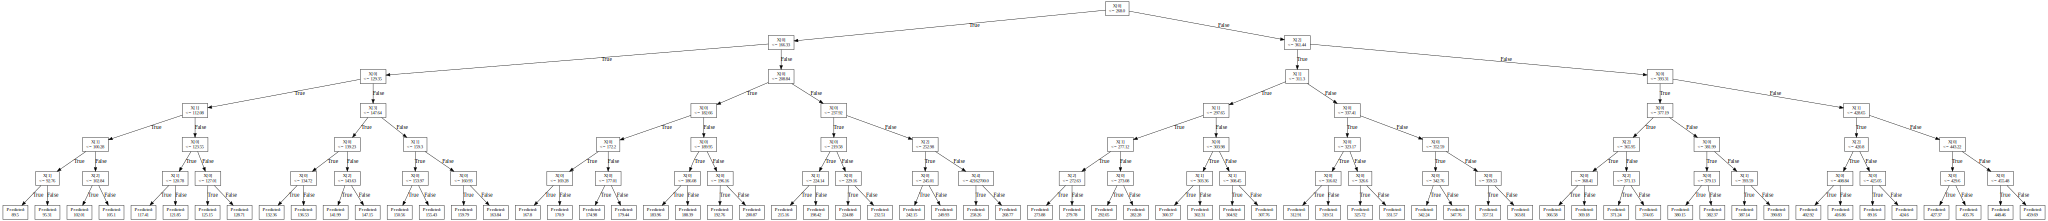

In [ ]:
def visualize_tree(node, dot=None, node_id=0):
    if dot is None:
        dot = Digraph()
        dot.attr('node', shape='box', fontsize='12')

    current_id = str(node_id)

    # Gán nhãn cho nút
    if node.value is not None:
        label = f"Predicted:\n{round(node.value, 2)}"
    else:
        label = f"X[{node.feature_index}]\n<= {round(node.threshold, 2)}"

    dot.node(current_id, label)
    next_id = node_id + 1

    # Vẽ nhánh trái
    if node.left:
        left_id = str(next_id)
        dot.edge(current_id, left_id, label="True")
        dot, next_id = visualize_tree(node.left, dot, next_id)

    # Vẽ nhánh phải
    if node.right:
        right_id = str(next_id)
        dot.edge(current_id, right_id, label="False")
        dot, next_id = visualize_tree(node.right, dot, next_id)

    return dot, next_id

# Vẽ 1 câyS
dot, _ = visualize_tree(models['day'].trees[0])
display(dot)

# Vẽ tất cả các cây trong Random Forest day
# for i, tree in enumerate(models['day'].trees):
#     print(f"🌲 Cây số {i+1}")
#     dot, _ = visualize_tree(tree)
#     display(dot)

Tính toán RSME để tìm ra độ sâu tối đa (max_depth) và số cây trong rừng (n_estimators) tối ưu

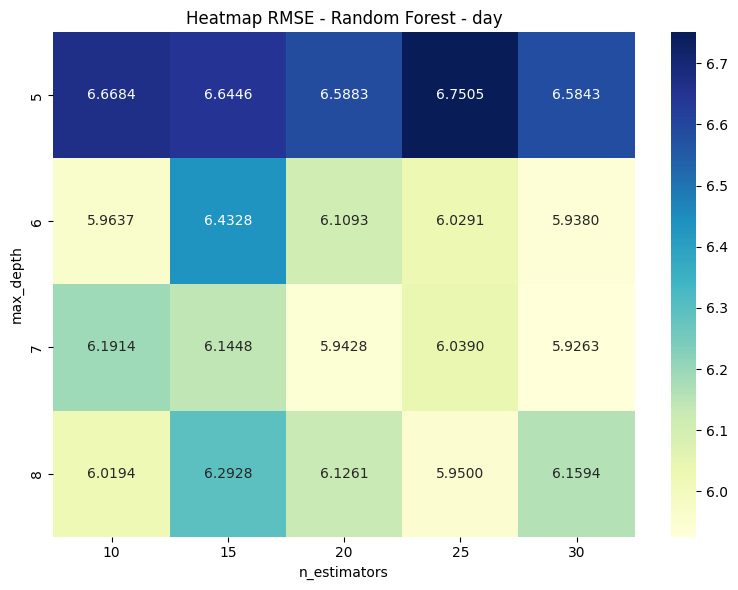

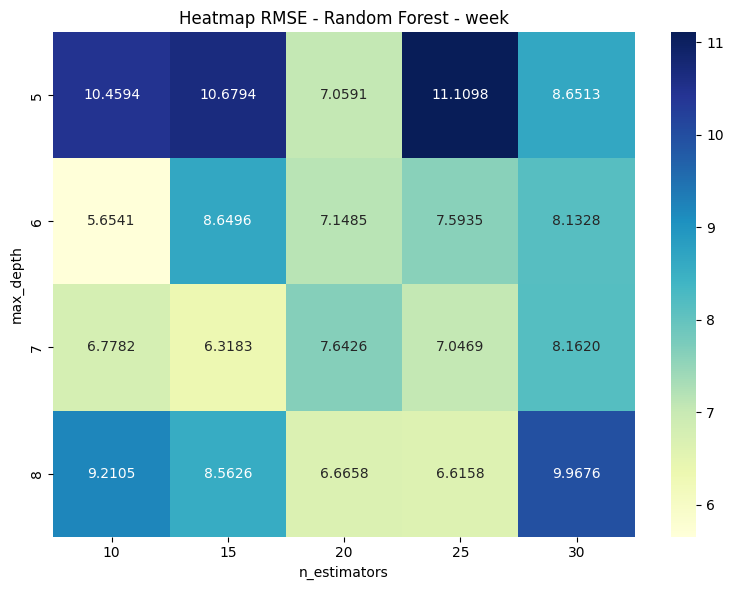

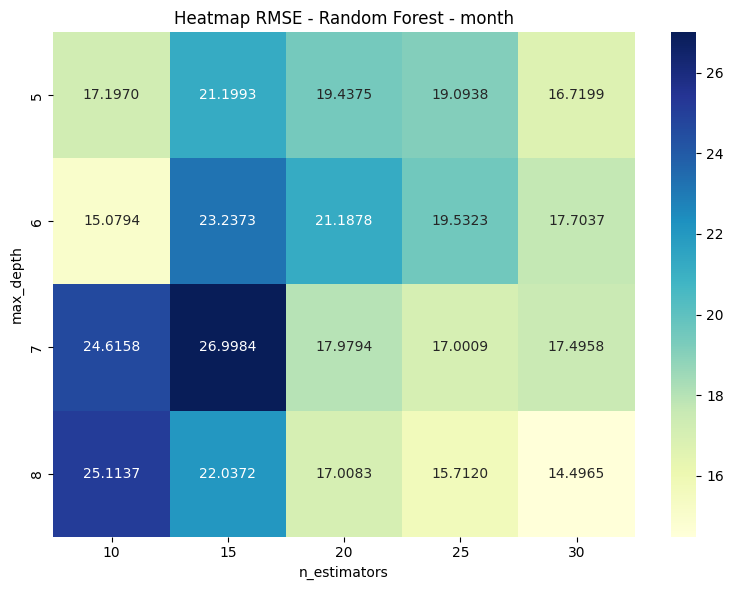

In [ ]:
max_depths = [5, 6, 7, 8]
n_estimators_list = [10, 15, 20, 25, 30]

# Tạo dictionary lưu kết quả RMSE cho từng output
results_dict = {time: pd.DataFrame(index=max_depths, columns=n_estimators_list) for time in times}

# Huấn luyện và đánh giá mô hình riêng cho từng output
for time in times:

    for depth in max_depths:
        for trees in n_estimators_list:
            model = RandomForestRegressor(n_estimators=trees, max_depth=depth)
            model.fit(X_train[time].values.tolist(), y_train[time])
            preds = model.predict(X_test[time].values.tolist())
            rmse = np.sqrt(mean_squared_error(y_test[time], preds))
            results_dict[time].loc[depth, trees] = round(rmse, 4)

# Vẽ heatmap cho từng output
for time in times:
    plt.figure(figsize=(8, 6))
    sns.heatmap(results_dict[time].astype(float), annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f"Heatmap RMSE - Random Forest - {time}")
    plt.xlabel("n_estimators")
    plt.ylabel("max_depth")
    plt.tight_layout()
    plt.show()

So sánh dữ liệu dữ đoán với dữ liệu thật

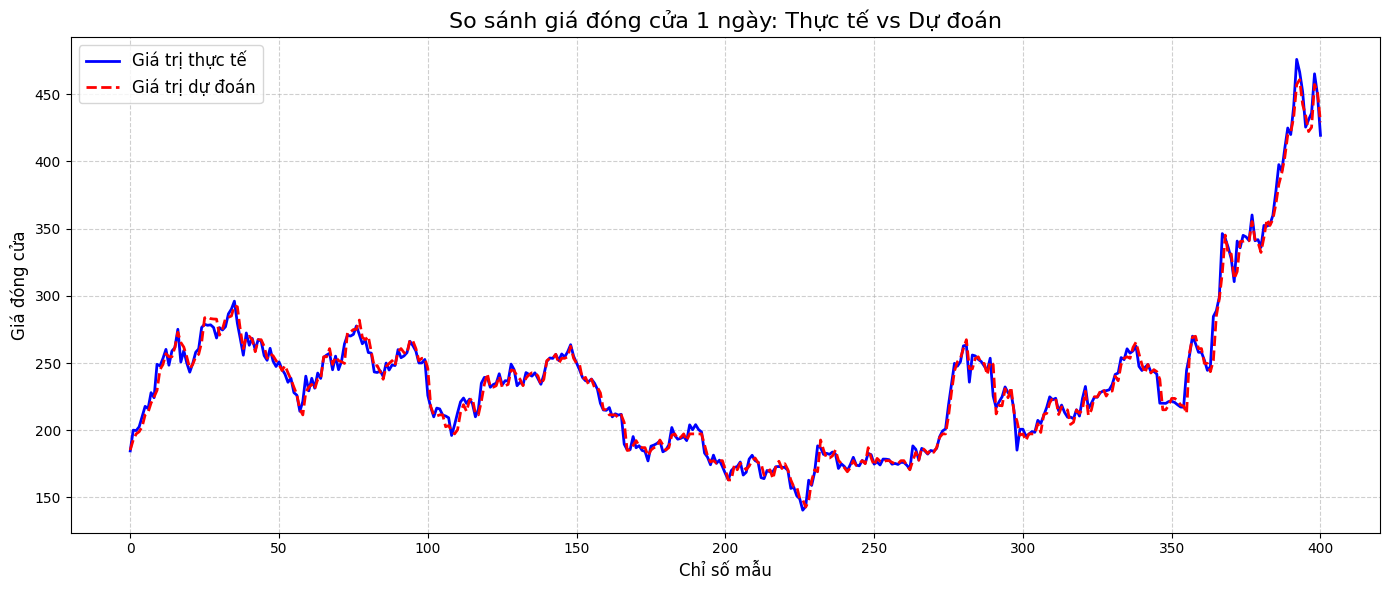

In [ ]:
# Lấy giá trị thực tế và dự đoán từ DataFrame
y_true = y_test['day'].values.tolist()
y_pred = predictions_df['day'].values.tolist()

# Tạo chỉ số trục x
x_range = list(range(len(y_true)))

# Tạo figure
plt.figure(figsize=(14, 6))  # 👈 mở rộng khung hình cho dễ nhìn

# Vẽ đường giá trị thật
plt.plot(x_range, y_true, label='Giá trị thực tế', color='blue', linewidth=2)

# Vẽ đường giá trị dự đoán
plt.plot(x_range, y_pred, label='Giá trị dự đoán', color='red', linestyle='--', linewidth=2)

# Trang trí biểu đồ
plt.title('So sánh giá đóng cửa 1 ngày: Thực tế vs Dự đoán', fontsize=16)
plt.xlabel('Chỉ số mẫu', fontsize=12)
plt.ylabel('Giá đóng cửa', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

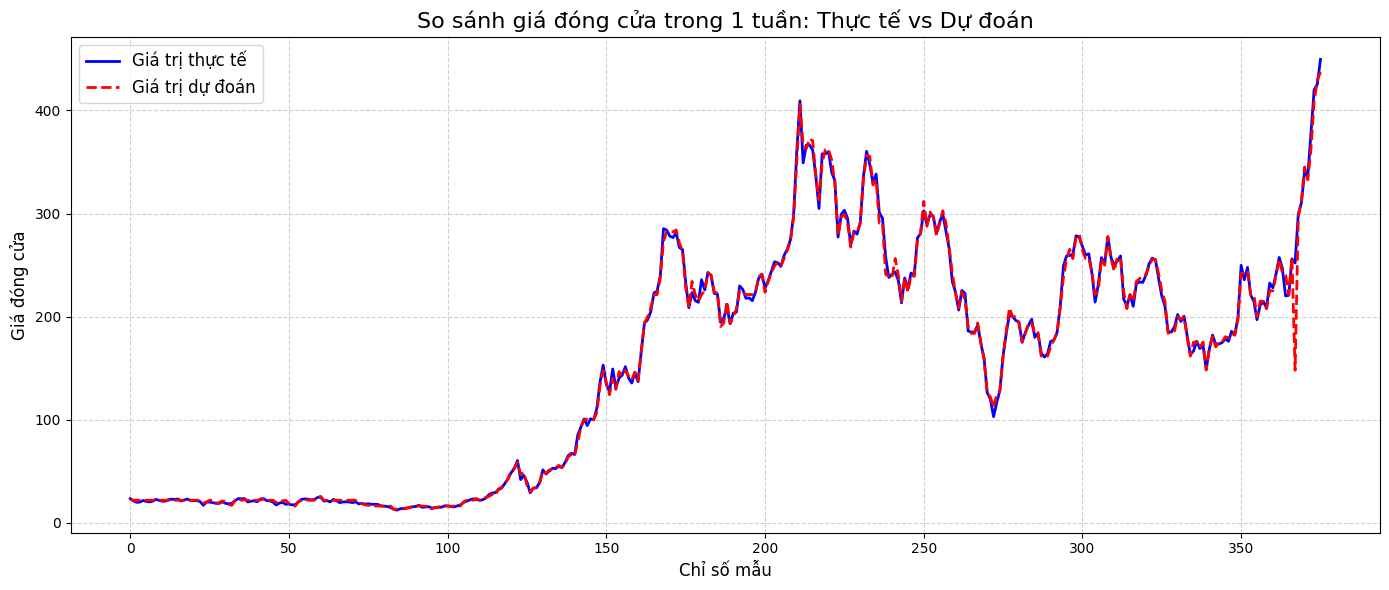

In [ ]:
# Lấy giá trị thực tế và dự đoán từ DataFrame
y_true = y_test['week'].values.tolist()
y_pred = predictions_df['week'].values.tolist()

# Tạo chỉ số trục x
x_range = list(range(len(y_true)))

# Tạo figure
plt.figure(figsize=(14, 6))  # 👈 mở rộng khung hình cho dễ nhìn

# Vẽ đường giá trị thật
plt.plot(x_range, y_true, label='Giá trị thực tế', color='blue', linewidth=2)

# Vẽ đường giá trị dự đoán
plt.plot(x_range, y_pred, label='Giá trị dự đoán', color='red', linestyle='--', linewidth=2)

# Trang trí biểu đồ
plt.title('So sánh giá đóng cửa trong 1 tuần: Thực tế vs Dự đoán', fontsize=16)
plt.xlabel('Chỉ số mẫu', fontsize=12)
plt.ylabel('Giá đóng cửa', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

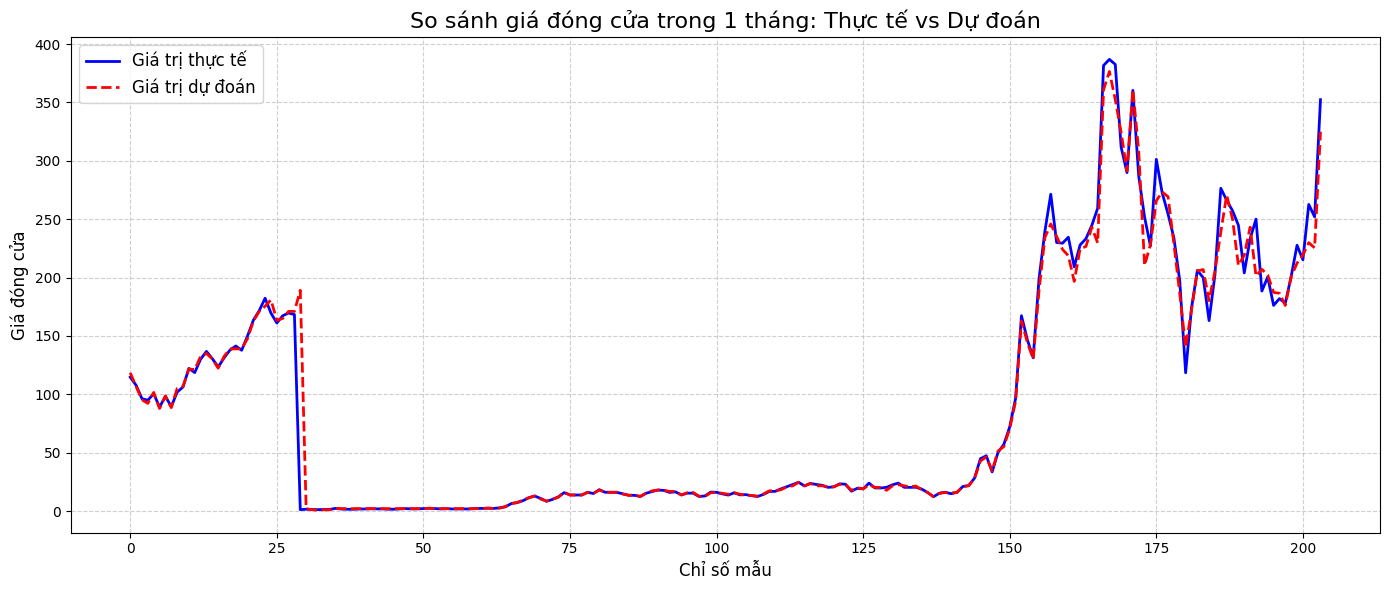

In [ ]:
# Lấy giá trị thực tế và dự đoán từ DataFrame
y_true = y_test['month'].values.tolist()
y_pred = predictions_df['month'].values.tolist()

# Tạo chỉ số trục x
x_range = list(range(len(y_true)))

# Tạo figure
plt.figure(figsize=(14, 6))  # 👈 mở rộng khung hình cho dễ nhìn

# Vẽ đường giá trị thật
plt.plot(x_range, y_true, label='Giá trị thực tế', color='blue', linewidth=2)

# Vẽ đường giá trị dự đoán
plt.plot(x_range, y_pred, label='Giá trị dự đoán', color='red', linestyle='--', linewidth=2)

# Trang trí biểu đồ
plt.title('So sánh giá đóng cửa trong 1 tháng: Thực tế vs Dự đoán', fontsize=16)
plt.xlabel('Chỉ số mẫu', fontsize=12)
plt.ylabel('Giá đóng cửa', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

3. Đánh giá mô hình

In [ ]:
# Tính MAE
mae = mean_absolute_error(y_true, y_pred)

# Tính RMSE thủ công (nếu không hỗ trợ squared=False)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# In kết quả
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")


MAE (Mean Absolute Error): 5.5272
RMSE (Root Mean Squared Error): 18.4687


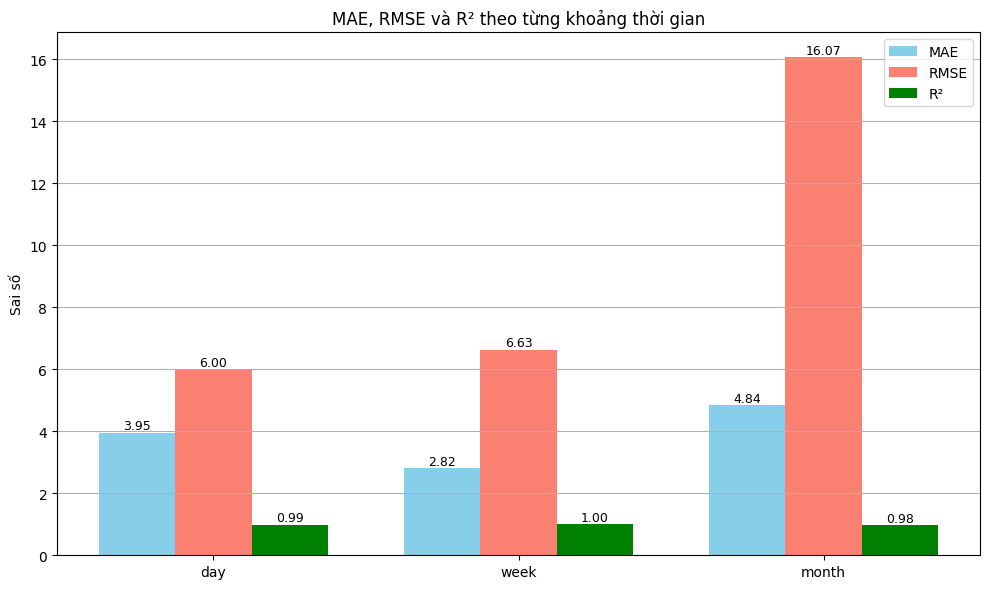

In [ ]:
maes = []
rmses = []
rs = []

for time in times:
    y_true = y_test[time].values.tolist()
    y_pred = predictions_df[time].values.tolist()
    maes.append(mean_absolute_error(y_true, y_pred))
    rmses.append(np.sqrt(mean_squared_error(y_true, y_pred)))
    rs.append(r2_score(y_true, y_pred))

# Vẽ biểu đồ cột
x = np.arange(len(times))
width = 0.25

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width, maes, width, label='MAE', color='skyblue')
bar2 = plt.bar(x, rmses, width, label='RMSE', color='salmon')
bar3 = plt.bar(x + width, rs, width, label='R²', color='green')

# Thêm số trên đỉnh cột
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}',
                 ha='center', va='bottom', fontsize=9)

plt.xticks(x, times)
plt.ylabel("Sai số")
plt.title("MAE, RMSE và R² theo từng khoảng thời gian")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

4. Áp dụng mô hình để dự đoán

Áp dụng với NVDA

In [ ]:
nvda=yf.download("NVDA", start="2025-01-01", end="2025-04-22")
nvda_flat = nvda.stack(level=1).reset_index()
nvda_flat.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
nvda_flat.dropna(inplace=True)
# Tạo dữ liệu dự báo là dữ liệu của ngày hôm sau
nvda_flat['Target_day'] = nvda_flat['Close'].shift(-1)

nvda_flat.dropna(inplace=True)
nvda_flat

[*********************100%***********************]  1 of 1 completed
<ipython-input-27-57e100b953a3>:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nvda_flat = nvda.stack(level=1).reset_index()


,Date,Ticker,Open,High,Low,Close,Volume,Target_day
0,2025-01-02,NVDA,138.297272,138.867227,134.617618,135.987487,198247200,139.997114
1,2025-01-03,NVDA,144.456711,144.886664,139.717141,139.997114,229322500,148.576325
2,2025-01-06,NVDA,149.416245,152.146004,147.806407,148.576325,265377400,153.015919
3,2025-01-07,NVDA,140.127106,153.115916,139.997113,153.015919,351782200,142.566896
4,2025-01-08,NVDA,140.097122,143.936766,137.547354,142.566896,227349900,137.437358
...,...,...,...,...,...,...,...,...
68,2025-04-11,NVDA,110.930000,111.550003,107.480003,108.500000,313417300,114.110001
69,2025-04-14,NVDA,110.709999,114.290001,109.070000,114.110001,264705000,110.970001
70,2025-04-15,NVDA,112.199997,113.620003,110.500000,110.970001,228966900,104.550003
71,2025-04-16,NVDA,104.489998,106.790001,100.449997,104.550003,397016900,104.449997


In [ ]:
X_nvda_test = nvda_flat[['Open', 'High', 'Low', 'Close', 'Volume']]
y_nvda_test = nvda_flat[['Target_day']]

predictions = {}

model = models['day']
predictions['Target_day'] = model.predict(X_nvda_test.values.tolist())

# Chuyen sang DataFrame de hien thi ket qua
nvda_predict_df = pd.DataFrame(predictions)
nvda_predict_df.columns = [col for col in nvda_predict_df.columns]
nvda_predict_df

,Target_day
0,137.119238
1,147.307669
2,149.139190
3,145.853970
4,142.775255
...,...
68,109.334603
69,112.165169
70,114.344264
71,102.831026


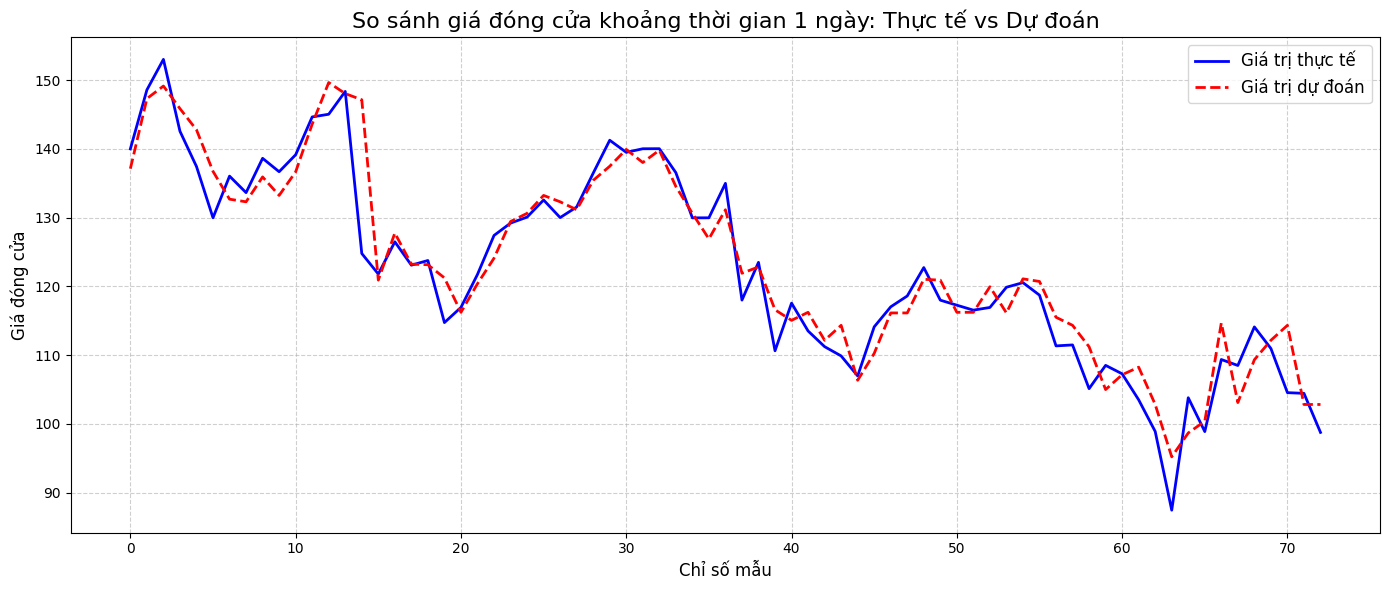

In [ ]:
# Lấy giá trị thực tế và dự đoán từ DataFrame
y_nvda_true = y_nvda_test['Target_day'].values.tolist()
y_nvda_pred = nvda_predict_df['Target_day'].values.tolist()

# Tạo chỉ số trục x
x_range = list(range(len(y_nvda_true)))

# Tạo figure
plt.figure(figsize=(14, 6))  # 👈 mở rộng khung hình cho dễ nhìn

# Vẽ đường giá trị thật
plt.plot(x_range, y_nvda_true, label='Giá trị thực tế', color='blue', linewidth=2)

# Vẽ đường giá trị dự đoán
plt.plot(x_range, y_nvda_pred, label='Giá trị dự đoán', color='red', linestyle='--', linewidth=2)

# Trang trí biểu đồ
plt.title('So sánh giá đóng cửa khoảng thời gian 1 ngày: Thực tế vs Dự đoán', fontsize=16)
plt.xlabel('Chỉ số mẫu', fontsize=12)
plt.ylabel('Giá đóng cửa', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

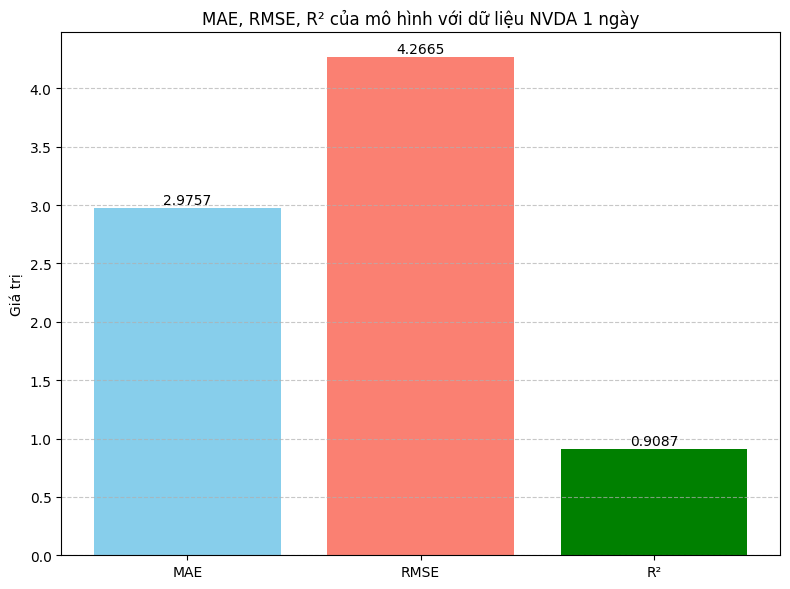

In [ ]:
# Dữ liệu
metrics = ['MAE', 'RMSE', 'R²']
values = [maes, rmses, rs]

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['skyblue', 'salmon', 'green'])

# Thêm số trên đỉnh cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.title("MAE, RMSE, R² của mô hình với dữ liệu NVDA 1 ngày")
plt.ylabel("Giá trị")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

5. So sánh Random Forest với mô hình khác

Linear Regression - MAE: 8.1384
Linear Regression - RMSE: 17.8874
Linear Regression - R² Score: 0.9693


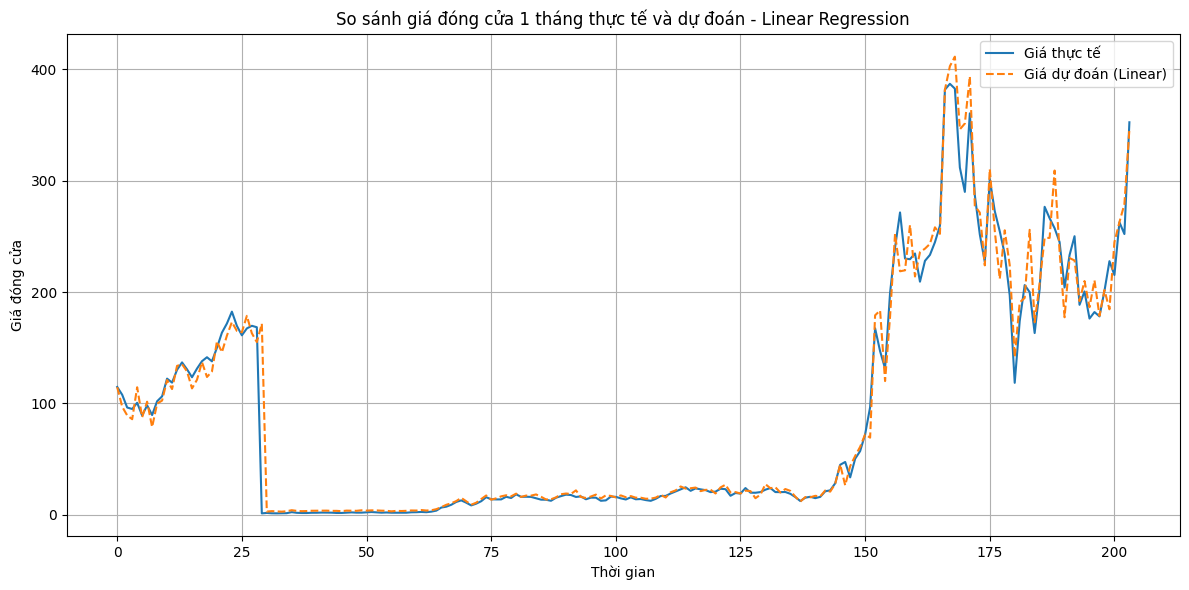

In [ ]:
# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(X['month'], y['month'], test_size=0.2, shuffle=False)

# Huấn luyện mô hình Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Dự đoán
y_pred = lr_model.predict(X_test)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression - MAE: {mae:.4f}")
print(f"Linear Regression - RMSE: {rmse:.4f}")
print(f"Linear Regression - R² Score: {r2:.4f}")

# Vẽ biểu đồ so sánh giá thực và dự đoán
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Giá thực tế' )
plt.plot(y_pred, label='Giá dự đoán (Linear)', linestyle='--')
plt.title('So sánh giá đóng cửa 1 tháng thực tế và dự đoán - Linear Regression')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lưu mô hình

In [ ]:
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [ ]:
from google.colab import files
files.download('models.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
joblib.dump(models, 'models2.pkl')
from google.colab import files
files.download('models2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(type(models['day']))

<class '__main__.RandomForestRegressor'>


In [ ]:
from google.colab import files

# Chạy dòng này → sẽ hiện nút chọn file
uploaded = files.upload()


Saving full_code.py to full_code.py


In [ ]:
import os
os.makedirs("models", exist_ok=True)

In [ ]:
!mv full_code.py models/full_code.py

In [ ]:
from models.full_code import RandomForestRegressor, RegressionTreeNode, best_split, mse

# --- Huấn luyện riêng từng mô hình để dự đoán các chỉ số ---
models = {}
predictions = {}
times = ['day', 'week', 'month']

for time in times:
    model = RandomForestRegressor(n_estimators=10, max_depth=6)
    model.fit(X_train[time].values.tolist(), y_train[time])
    models[time] = model
    predictions[time] = model.predict(X_test[time].values.tolist())

In [ ]:
print(type(models['day']))

<class 'models.full_code.RandomForestRegressor'>


In [ ]:
import joblib
joblib.dump(models, 'models2.pkl')
from google.colab import files
files.download('models2.pkl')

NameError: name 'ridge_regression' is not defined